# Regularization

Lp norm:
$$
|\beta|_{\ell_p} = \sum_{i=1}^{p} |\beta_j|^{p}
$$

Specifically, 
$$
|\beta|_{\ell_1} = \sum_{i=1}^{p} |\beta_j|, \quad |\beta|^2 = \sum_{i=1}^{p} \beta_j^2
$$

## Ridge Regression

Ridge regression introduces L2 regularization to $\beta$.

* Least squares: $R(\beta) = |Y-X\beta|^2$

* Ridge regression: $f(\beta) = R(\beta) + \lambda|\beta|^2$

To find the solution, we take derivative: 
$$
\begin{align}
f'(\beta) =-2X^T (Y - X\beta) + 2\lambda\beta^2 &= 0 \\
(X^TX + \lambda I) \beta &= X^T Y,
\end{align}
$$

Hence, 
$$
\hat{\beta} = (X^TX + \lambda I)^{-1} X^T Y.
$$

Let $A = X^TX + \lambda I$, the solution exists as long as $A$ is a positive definite matrix, i.e. $v^T A v > 0, \forall v$.

The following code segment implements a ridge regression solver using the sweep operator.

In [1]:
import numpy as np

def sweep(A, k):
    """
    Perform a SWEEP operation on A with the pivot element A[k,k].
    
    :param A: a square matrix.
    :param k: the pivot element is A[k, k].
    :returns a swept matrix. Original matrix is unchanged.
    """
    n = A.shape[0]
    if A.shape != (n, n):
        raise ValueError('A is not a square array.')
    if k >= n or k < 0:
        raise IndexError('k is not a valid row index for pivot element.')
        
    # Fill with the general formula
    B = A - np.outer(A[:, k], A[k, :]) / A[k, k]
    
    # Modify the k-th row and column
    B[k, :] = A[k, :] / A[k, k]
    B[:, k] = A[:, k] / A[k, k]
    
    # Modify the pivot
    B[k, k] = -1 / A[k, k]
    return B

def ridge(X, y, lam):
    n, p = X.shape
    Z = np.column_stack((np.ones((n,1)), X, y))
    A = Z.T.dot(Z)
    D = np.eye(p+2) * lam
    D[0, 0] = 0
    D[-1, -1] = 0
    A = A + D
    for k in xrange(p+1):
        A = sweep(A, k)
    beta = A[0:p+1, p+1]
    return beta

## Spline Regression

Consider the linear spline (piecewise linear) function
$$
g(x) = \beta_0 + \sum_{j=0}^{p} \beta_j \cdot \max(0, x-k_j),
$$
where $\beta_j$ is the change of slope at $k_j$.

We assume the observations can be modeled by the a linear spline function
$$
\begin{align}
y_i &= g(x_i) + \epsilon_i \\
&= \beta_0 + \sum_{j=1}^{p} \beta_j \cdot \max(0, x_i-k_j) + \epsilon_i.
\end{align}
$$

Therefore, the objective function is:
$$
\sum_{i=1}^{n}\left[ y_i - \left(\beta_0 + \sum_{j=1}^{p} \beta_j \cdot \max(0, x_i-k_j)\right) \right]^2 + \lambda \sum_{i=1}^{p} \beta_j^2.
$$

### A Simple Example

Here as a simple example, we assume $x_i$'s are one dimentional and
$$y_i = x_i^2 + \epsilon_i.$$

The following code uses the ridge solver, but fit a spline.

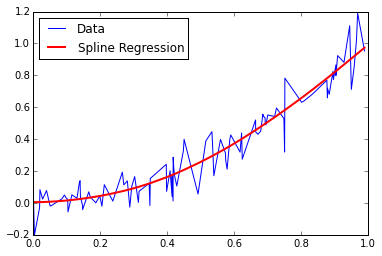

In [2]:
np.random.seed(1)

n = 100
sigma = 0.1

# Generate a set of true two dimensional points (x, y)
# lies around a quadratic spline.
x = np.sort(np.random.uniform(size=n))
y = x**2 + np.random.standard_normal(size=n)*sigma

def spline(x, beta=None, p=500, lam=10):
    # Generate p-1 additional features.
    X = np.copy(x)
    n = x.shape[0]
    for k in (np.arange(1, p, dtype='float')/p):
        X = np.column_stack((X, (x > k)*(x - k)))

    if beta is None:
        # Fit a spline using ridge regression.
        beta = ridge(X, y, lam)
    y_hat = np.hstack((np.ones((n, 1)), X)).dot(beta)
    return y_hat, beta

y_hat, beta = spline(x)

# Plot the original data and regression results.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(x, y, color='blue', label='Data')
plt.plot(x, y_hat, color='red', label='Spline Regression', linewidth=2)
plt.legend(loc=2)
plt.xlim(0, 1)
plt.ylim(-0.2, 1.2)
plt.show()

To find a optimal lambda, we usually try multiple options and plot the errors for training set and testing set respectively.

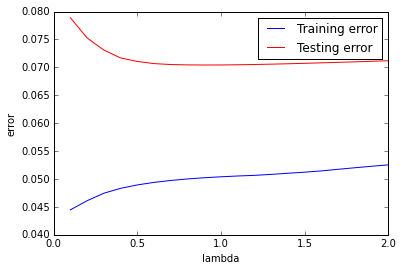

In [3]:
n = 20
sigma = 0.1

np.random.seed(5)
# Generate a set of true two dimensional points (x, y)
# lies around a quadratic spline.
x = np.sort(np.random.uniform(size=n))
y = x**2 + np.random.standard_normal(size=n)*sigma

np.random.seed(2)
x_test = np.sort(np.random.uniform(size=n))
y_test = x_test**2 + np.random.standard_normal(n)*sigma

errors_train = []
errors_test = []

lambdas = np.linspace(0.1, 2, 20)
for lam in lambdas:
    y_hat, beta = spline(x, p=100, lam=lam)
    y_test_hat, _ = spline(x_test, beta, p=100, lam=lam)
    
    err_train = np.sum(np.abs(y_hat - y)) / y.shape[0]
    errors_train.append(err_train)
    
    err_test = np.sum(np.abs(y_test_hat - y_test)) / y_test.shape[0]
    errors_test.append(err_test)
    
plt.figure()
plt.plot(lambdas, errors_train, color='b', label='Training error')
plt.plot(lambdas, errors_test, color='r', label='Testing error')
plt.ylabel('error')
plt.xlabel('lambda')
plt.legend()
plt.show()

## LASSO Regression

It means least-absolute shrinkage selective operator. It adds a $\ell_1$ regularization to induce sparcity (i.e. many of $\beta_j$'s are zero.)

$$
f(\beta) = |Y - X\beta|^2 + \lambda|\beta|_{\ell_1}
$$